In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw3-diatom.ipynb")

In [2]:
import numpy as np
import pandas as pd
import altair as alt
from sklearn.decomposition import PCA
import statsmodels.api as sm
# disable row limit for plotting
alt.data_transformers.disable_max_rows()
# uncomment to ensure graphics display with pdf export
alt.renderers.enable('mimetype')

RendererRegistry.enable('mimetype')

# Background: diatoms and paleoclimatology

Diatoms are a type of phytoplankton -- they are photosynthetic algae that function as primary producers in aquatic ecosystems. Diatoms are at the bottom of the food web: they are consumed by filter feeders, like clams, mussels, and many fish, which are in turn consumed by larger organisms like scavengers and predators and, well, us. As a result, changes in the composition of diatom species in marine ecosystems have ripple effects that can dramatically alter overall community structure in any environment of which marine life forms a part. 

Diatoms have glass bodies. As a group of organisms, they display a great diversity of body shapes, and many are quite elaborate. The image below, taken from a Scientific American article, shows a small sample of their shapes and structures.

<center><img src='figures/diatoms-sciam.jpg' style='width:400px'></center>

Because they are made of glass, diatoms preserve extraordinarily well over time. When they die, their bodies sink and form part of the sediment. Due to their abundance, there is a sort of steady rain of diatoms forming part of the sedimentation process, which produces sediment layers that are dense with diatoms.

Sedimentation is a long-term process spanning great stretches of time, and the deeper one looks in sediment, the older the material. Since diatoms are present in high density throughout sedimentation layers, and they preserve so well, it is possible to study their presence over longer time spans -- potentially hundreds of thousands of years. 

A branch of paleoclimatology is dedicated to studying changes in biological productivity on geologic time scales, and much research in this area has involved studying the relative abundances of diatoms. In this assignment, you'll do just that on a small scale and work with data from sediment cores taken in the gulf of California at the location indicated on the map:

<center><img src='figures/site1-barron2004.png' style='width:400px'></center>

The data is publicly available: 
> Barron, J.A., *et al.* 2005. High Resolution Guaymas Basin Geochemical, Diatom, and Silicoflagellate Data. IGBP PAGES/World Data Center for Paleoclimatology Data Contribution Series # 2005-022. NOAA/NGDC Paleoclimatology Program, Boulder CO, USA.

In this assignment, you'll use the exploratory techniques we've been discussing in class to analyze the relative abundances of diatom taxa over a time span of 15,000 years. This will involve practicing the following:

* data import and preprocessing
* graphical techniques for visualizing distributions
* multivariate analysis with PCA

# Diatom data

The data are diatom counts sampled from evenly-spaced depths in a sediment core from the gulf of California. In sediment cores, depth correlates with time before the present -- deeper layers are older -- and depths are typically chosen to obtain a desired temporal resolution. The counts were recorded by sampling material from sediment cores at each depth, and examining the sampled material for phytoplankton cells. For each sample, phytoplankton were identified at the taxon level and counts of diatom taxa were recorded along with the total number of phytoplankton cells identified. Thus:

* The **observational units** are _**sediment samples**_.  
* The **variables** are _**depth (age), diatom abundance counts, and the total number of identified phytoplankton**_. Age is inferred from radiocarbon. 
* One **observation** is made at _**each depth**_ from 0cm (surface) to  13.71 cm. 

The table below provides variable descriptions and units for each column in the dataframe.

Variable | Description | Units
---|---|---
Depth | Depth interval location of sampled material in sediment core | Centimeters (cm)
Age | Radiocarbon age | Thousands of years before present (KyrBP)
A_curv | Abundance of *Actinocyclus curvatulus* | Count (n)
A_octon | Abundance of *Actinocyclus octonarius* | Count (n)
ActinSpp | Abundance of *Actinoptychus* species | Count (n)
A_nodul | Abundance of *Azpeitia nodulifer* | Count (n)
CocsinSpp | Abundance of *Coscinodiscus* species | Count (n)
CyclotSpp | Abundance of *Cyclotella* species | Count (n)
Rop_tess | Abundance of *Roperia tesselata* | Count (n)
StephanSpp | Abundance of *Stephanopyxis* species | Count (n)
Num.counted | Number of diatoms counted in sample | Count (n)

The cell below imports the data.

In [3]:
# import diatom data
diatoms_raw = pd.read_csv('data/barron-diatoms.csv')
diatoms_raw.head(5)

,Depth,Age,A_curv,A_octon,ActinSpp,A_nodul,CoscinSpp,CyclotSpp,Rop_tess,StephanSpp,Num.counted
0,0.00,1.33,5.0,2.0,32,14.0,21,22.0,1.0,1.0,201
1,0.05,1.37,8.0,2.0,31,16.0,20,16.0,7.0,2.0,200
2,0.10,1.42,8.0,6.0,33,18.0,29,7.0,1.0,1.0,200
3,0.15,1.46,11.0,1.0,21,1.0,12,28.0,25.0,3.0,200
4,0.20,1.51,11.0,1.0,38,3.0,18,24.0,3.0,NaN,300


The data are already in tidy format, because each row is an observation (a set of measurements on one sample of sediment) and each column is a variable (one of age, depth, or counts). However, examine rows 3 and 4, and note:

1. NaNs are present
2. The number of individuals counted in each sample varies by a lot from sample to sample.

Let's address those before conducting initial explorations.

The NaNs are an artefact of the data recording -- if *no* diatoms in a particular taxa are observed, a `-` is entered in the table (you can verify this by checking the .csv file). In these cases the value isn't missing, but rather zero. These entries are parsed by pandas as NaNs, but they correspond to a value of 0 (no diatoms observed). 

### Question 1: Filling NaNs

Use `.fill_na()` to replace all NaNs by zeros, and store the result as `diatoms_mod1`. Store rows 4 and 5 (index, not integer location) of the resulting dataframe as `diatoms_mod1_examplerows` and display these rows.

In [4]:
diatoms_mod1 = diatoms_raw.fillna(0)

# print rows 4 and 5
diatoms_mod1_examplerows = diatoms_mod1.loc[[4,5]]
print(diatoms_mod1_examplerows)

   Depth   Age  A_curv  A_octon  ActinSpp  A_nodul  CoscinSpp  CyclotSpp  \
4   0.20  1.51    11.0      1.0        38      3.0         18       24.0   
5   0.25  1.55     4.0      9.0        30     10.0         16       14.0   

   Rop_tess  StephanSpp  Num.counted  
4       3.0         0.0          300  
5      16.0         0.0          203  


In [5]:
grader.check("q1")

q1 results: All test cases passed!

Since the total number of phytoplankton counted in each sample varies, the raw counts are not directly comparable -- *e.g.*, a count of 18 is actually a *different* abundance in a sample with 200 individuals counted than in a sample with 300 individuals counted.

For exploratory analysis, you'll want the values to be comparable across rows. This can be achieved by a simple transformation so that the values are *relative* abundances: *proportions* of phytoplankton observed from each taxon.

### Question 2: Counts to proportions

Convert the counts to proportions by dividing by the relevant entry in the `Num.counted` column. There are a few ways to do this, but here's one approach:

1. Set Depth and Age to row indices using `.set_index(...)` and store the result as `diatoms_mod2`.
2. Store the `Num.counted` column from `diatoms_mod2` as `sampsize`.
3. Use `.div(...)` to divide entrywise every column in `diatoms_mod2` by `sampsize` and store the result as `diatoms_mod3`.
4. Drop the `Num.counted` column from `diatoms_mod3` and reset the index; store the result as `diatoms`.

Carry out these steps and print the first four rows of `diatoms`.

(*Hint*: careful with the `axis = ...` argument in `.div(...)`; you may want to look at the [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.div.html) and check one or two values manually to verify the calculation works as intended.)


In [6]:
# set depth, age to indices
diatoms_mod2 = diatoms_mod1.set_index(['Depth', 'Age'])

# store sample sizes
sampsize = diatoms_mod2['Num.counted']

# divide
diatoms_mod3 = diatoms_mod2.div(sampsize,  axis = 'index')

# drop num.counted and reset index
diatoms = diatoms_mod3.drop(columns = 'Num.counted').reset_index()

# print
diatoms.head()

,Depth,Age,A_curv,A_octon,ActinSpp,A_nodul,CoscinSpp,CyclotSpp,Rop_tess,StephanSpp
0,0.00,1.33,0.024876,0.009950,0.159204,0.069652,0.104478,0.109453,0.004975,0.004975
1,0.05,1.37,0.040000,0.010000,0.155000,0.080000,0.100000,0.080000,0.035000,0.010000
2,0.10,1.42,0.040000,0.030000,0.165000,0.090000,0.145000,0.035000,0.005000,0.005000
3,0.15,1.46,0.055000,0.005000,0.105000,0.005000,0.060000,0.140000,0.125000,0.015000
4,0.20,1.51,0.036667,0.003333,0.126667,0.010000,0.060000,0.080000,0.010000,0.000000


In [7]:
grader.check("q2")

q2 results: All test cases passed!

Take a moment to think about what the data represent. They are relative abundances over time; essentially, snapshots of the community composition of diatoms over time, and thus information about how ecological community composition changes.

Before diving in, it will be helpful to resolve two matters:

1. How far back in time do the data go?
2. What is the time resolution of the data?

### Question 3: Time span

What is the geological time span covered by the data? Compute the minimum and maximum age using `.aggregate(...)` and store the result as `min_max_age`. (You will need to use `.aggregate()` to pass the automated tests.)

*Note*: This may be a new function for you, but it's simple: it takes as an argument a list of functions that will be applied to the dataframe (columnwise by default). So for example, to get the mean and variance of each column in `df`, one would use `df.aggregate(['mean', 'var'])`. See the [documentation](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.aggregate.html) for further examples.

*Remember*: age is reported as thousands of years before present, so `Age = 2` means 2000 years ago.

In [8]:
min_max_age = diatoms['Age'].aggregate(['min', 'max'])
min_max_age

min     1.33
max    15.19
Name: Age, dtype: float64

In [9]:
grader.check("q3")

q3 results: All test cases passed!

<!-- BEGIN QUESTION -->

### Question 4: Time resolution

**(i) How are the observations spaced in time?**

Follow these steps:

1. Extract the `Age` column from `diatoms`, sort the values in ascending order, compute the differences between consecutive rows, and store the result as `diffs`.
    + *Hint*: use `.sort_values()` and `.diff()`.
    + *Notice*: that the first difference is NaN, because there is no previous value to compare the first row with. Drop this entry when you store `diffs`.
2. Make a simple count histogram (no need to manually bin or convert to density scale) with bins of width 0.02 (20 years). Store this as `fig1` and display the figure.
    + Label the x axis 'Time step between consecutive samples'
    + Put the y axis on a square root scale so that bins with one observation are discernible

**(ii) What is the typical time step in years?**

Write your answer based on the count histogram.

The observations are generally about 20-100 years apart with some consecutive samples even exceeding 1000 years apart. The typical time step is 0.04-0.06 which means the observations are usually about 40-60 years apart.

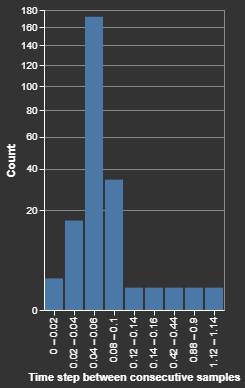

In [10]:
# store differences
diffs = diatoms['Age'].sort_values().diff().iloc[1:].rename('diff').to_frame()

# construct histogram
fig1 = alt.Chart(diffs).mark_bar().encode(
    x = alt.X('diff:O', bin=alt.Bin(step=0.02), title='Time step between consecutive samples'),
    y = alt.Y('count()', scale=alt.Scale(type='sqrt'), title='Count')
)

# display
fig1

In [11]:
grader.check("q4")

q4 results: All test cases passed!

<!-- END QUESTION -->

# Univariate explorations

To begin, you'll examine the variation in relative abundance over time for the eight individual taxa, one variable at a time.

Here are some initial questions in this spirit that will help you to hone in and develop more focused exploratory questions:
* Which taxa are most and least abundant on average over time?
* Which taxa vary the most over time?

These can be answered by computing simple summary statistics for each column in the diatom data.

### Question 5: Summary statistics

Use `.aggregate(...)` to find the mean and standard deviation of relative abundances for each taxon. Follow these steps:

1. Drop the depth and age variables before performing the aggregation.
2. Use `.transpose()` to ensure that the table is rendered in long form (8 rows by 2 columns rather than 2 columns by 8 rows). 
3. Store the resulting dataframe as `diatom_summary` display.


In [12]:
diatom_summary = diatoms.drop(columns = ['Depth', 'Age']).aggregate(['mean', 'std']).transpose()

# print the dataframe
diatom_summary


,mean,std
A_curv,0.028989,0.018602
A_octon,0.018257,0.016465
ActinSpp,0.135900,0.053797
A_nodul,0.072940,0.092677
CoscinSpp,0.085925,0.031795
CyclotSpp,0.070366,0.042423
Rop_tess,0.060448,0.076098
StephanSpp,0.002447,0.007721


In [13]:
grader.check("q5")

q5 results: All test cases passed!

It will be easier to determine which taxa are most/least abundant and most variable by displaying this information visually.

<!-- BEGIN QUESTION -->

### Question 6: Visualizing summary statistics

**(i) Create a plot of the average relative abundances and their variation over time.**

1. Reset the index of `diatom_summary` so that the taxon names are stored as a column and not an index. Store the result as `plot_df`.
2. Create an Altair chart based on `plot_df` with *no marks* -- just `alt.Chart(...).encode(...)` -- and pass the columnn of taxon names to the `Y` encoding channel with the title 'Taxon' and sorted in descending order of mean relative abundance. Store the result as `base`.
    + *Hint*: `alt.Y(..., sort = {'field': 'column', 'order': 'descending'})` will sort the Y channel by 'column' in descending order.
3. Modify `base` to create a point plot of the average relative abundances for each taxon; store the result as `means`.
    + Average relative abundance (the mean you calculated in Q1 (a)) should appear on the x axis, and taxon on the y axis.
    + Since the `Y` encoding was already specified in `base`, you do not need to add a `Y` encoding at this stage.
    + Give the x axis the title 'Average relative abundance'.
4. Modify `base` to create a plot with bars spanning two standard deviations in either direction from the mean. Store the result as `bars`.
    + First use `base.transform_calculate(...)` to compute `lwr` and `upr` for the positions of the bar endpoints:
        - $\texttt{lwr} = \texttt{mean} - 2\times\texttt{std}$
        - $\texttt{upr} = \texttt{mean} + 2\times\texttt{std}$.
    + Then append `.mark_errorbar().encode(...)` to the chain:
        - pass `lwr:Q` to the `X` encoding channel with the title 'Average relative abundance' (to match the point plot)
        - pass `upr:Q` to the `X2` encoding channel (no specific title needed).
5. Layer the plots: `means + bars`. Store the result as `fig2` and display the figure.

It may help to have a look at [this example](https://altair-viz.github.io/gallery/simple_scatter_with_errorbars.html).

**(ii) Based on the figure, answer the following questions.**

1. Which taxon is most abundant on average over time?
2. Which taxon is most rare on average over time?
3. Which taxon varies most in relative abundance over time?

ActinSpp or the Actinoptychus species is the most abundant on average over time and StephanSpp or the Stephanopyxis species is the rarest on average over time. The taxon that varies the most in relative abundance over time is the Azpeitia nodulifer.

/opt/conda/lib/python3.11/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


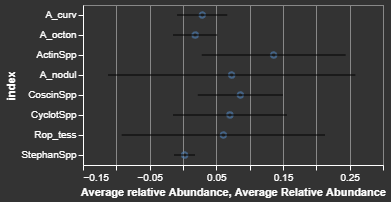

In [14]:
# reset index
plot_df = diatom_summary.reset_index()

# create base chart
base = alt.Chart(plot_df).encode(
    y = alt.Y('index',sort = {'field': 'column', 'order': 'descending'})
)

# create point plot
means = base.mark_point().encode(
    x = alt.X('mean', title = 'Average relative Abundance')
)

#create bar plot
bars = base.transform_calculate(
    lwr = 'datum.mean - 2 * datum.std',
    upr = 'datum.mean + 2 * datum.std'
).mark_errorbar().encode(
    x = alt.X('lwr:Q', title='Average Relative Abundance'),
    x2 = alt.X2('upr:Q')
)

# layer
fig2 = means + bars

# display
fig2

<!-- END QUESTION -->

Now that you have a sense of the typical abundances for each taxon (measured by means) and the variations in abundance (measured by standard deviations), you'll dig in a bit further and examine the variation in abundance of the most variable taxon.

<!-- BEGIN QUESTION -->

### Question 7: Distribution of *Azpeitia nodulifer* abundance over time

**(i) Construct a density scale histogram of the relative abundances of *Azpeitia nodulifer* and overlay a kernel density estimate.**

Use the `diatoms` dataframe and a bin width of 0.03. Be sure to choose an appropriate kernel and smoothing bandwidth. Store the result as `fig3`.

**(ii) Answer the following questions in a few sentences.**

* Which values are common?
* Which values are rare?
* How spread out are the values?
* Are values spread evenly or irregularly?

Values from 0 to about 0.03 are the most common while values greater than around 0.275 are rare. The values are not very spread out because most of them are close to 0 and the graph is skewed right. Other than that, the density seems to decrease with higher A_nodul abundance.

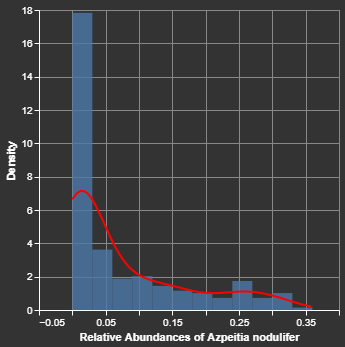

In [15]:
#density scale histogram
hist = alt.Chart(diatoms).transform_bin(
    as_ = ['bin_start', 'bin_end'],
    field = 'A_nodul',
    bin = alt.Bin(step=0.03)
).transform_aggregate(
    Count = 'count()',
    groupby = ['bin_start', 'bin_end']
).transform_calculate(
    Density='datum.Count / (230*0.03)',
    binshift='(datum.bin_start + datum.bin_end) / 2'
).mark_bar(size = 20, opacity = 0.8).encode(
    x = alt.X('binshift:Q', axis=alt.Axis(title="Relative Abundances of Azpeitia nodulifer")),
    y = alt.Y('Density:Q', axis=alt.Axis(title="Density"))
)

# compute density estimate
n, p = diatoms.shape
n
sigma_hat = diatoms.A_nodul.std()
bw_scott = 1.06*sigma_hat*n**(-1/5)
bw_scott

kde = alt.Chart(diatoms).transform_density(
    density = 'A_nodul',
    bandwidth = bw_scott,
    as_ = ['Azpeitia_nodulifer', 'density']
)

# plot kde
smooth = kde.mark_line(color='red').encode(
    x = 'Azpeitia_nodulifer:Q',
    y = 'density:Q'
)

# layer
fig3 = hist + smooth

# display
fig3

<!-- END QUESTION -->

> **Comment:** There are a disproportionately large number of zeroes, because in many samples no *Azpeitia nodulifer* diatoms were observed. This is a common phenomenon in ecological data, and even has a name: it results in a 'zero inflated' distribution of values. The statistician to identify and name the phenomenon was Diane Lambert in 1992. Zero inflation can present a variety of challenges. You may have noticed, for example, that there was no bandwidth parameter for the KDE that *both* captured the shape of the histogram near zero *and* away from zero, regardless of the choice of kernel. The key difficulty with zero inflated data is that no common probability distribution fits the data well. This requires the use of mixtures as probability models, which are challenging to incorporate into common statistical models.

There was a transition between geological epochs during the time span covered by the diatom data. The oldest data points in the diatom data correspond to the end of the Pleistocene epoch (ice age), at which time there was a pronounced warming (Late Glacial Interstadial, 14.7 - 12.9 KyrBP) followed by a return to glacial conditions (Younger Dryas, 12.9 - 11.7 KyrBP). 

This fluctuation can be seen from temperature reconstructions. Below is a plot of sea surface temperature reconstructions off the coast of Northern California. Data come from the following source:

> Barron *et al.*, 2003. Northern Coastal California High Resolution Holocene/Late Pleistocene Oceanographic Data. IGBP PAGES/World Data Center for Paleoclimatology. Data Contribution Series # 2003-014. NOAA/NGDC Paleoclimatology Program, Boulder CO, USA.

The shaded region indicates the time window with unusually large flucutations in sea surface temperature; this window roughly corresponds to the dates of the climate event.

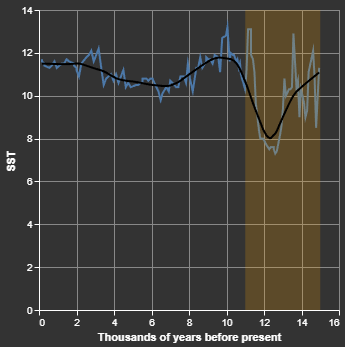

In [16]:
# import sea surface temp reconstruction
seatemps = pd.read_csv('data/barron-sst.csv')

# line plot of time series
line = alt.Chart(seatemps).mark_line().encode(
    x = alt.X('Age', title = 'Thousands of years before present'),
    y = 'SST'
)

# highlight region with large variations
highlight = alt.Chart(
    pd.DataFrame(
        {'SST': np.linspace(0, 14, 100), 
         'upr': np.repeat(11, 100), 
         'lwr': np.repeat(15, 100)}
    )
).mark_area(opacity = 0.2, color = 'orange').encode(
    y = 'SST',
    x = alt.X('upr', title = 'Thousands of years before present'),
    x2 = 'lwr'
)

# add smooth trend
smooth = line.transform_loess(
    on = 'Age',
    loess = 'SST',
    bandwidth = 0.2
).mark_line(color = 'black')

# layer
line + highlight + smooth

<!-- BEGIN QUESTION -->

### Question 8: Conditional distributions of relative abundance

Does the distribution of relative abundance of *Azpeitia nodulifer* differ when variation in sea temperatures was higher (before 11KyrBP)? 

**(i) Plot kernel density estimates to show the distribution of relative abundances before and after 11KyrBP.**

Use the Altair implementation of Gaussian KDE:
1. Use `.transform_caluculate(...)` to calculate an indicator variable, `pleistocene`, that indicates whether `Age` exceeds 11.
2. Use `.transform_density(...)` to compute KDEs separately for observations of relative abundance before and after 11KyrBP.
    + *Hint*: group by `pleistocene`
3. Plot the KDEs distinguished by color; give the color legend the title 'Before 11KyrBP' and store the plot as `kdes`.
4. Add a shaded area beneath the KDE curves. Adjust the opacity of the area to your liking.

Store the result as `fig4` and display the figure.

**(ii) Does the distribution seem to change between epochs? If so, how?**

Answer based on the figure in a few sentences.

The distribution definitely changes between epochs. Before 11 KyrBP, the distribution is much more spread out over values ranging from close to zero to above 0.35. Unlike the abundance after 11 KyrBP which has the vast majority of values close to zero. We can see that after 11KyrBP the abundance of this taxon has diminished a lot.

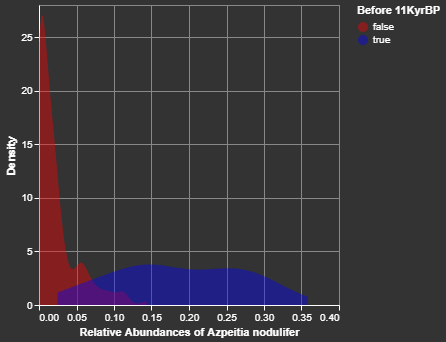

In [17]:
# 
kdes = alt.Chart(diatoms).transform_calculate(
     pleistocene = 'datum.Age > 11'
).transform_density(
    'A_nodul',
    groupby = ['pleistocene'],
    as_ = ['A_nodul', 'density']
).mark_area(opacity = 0.4).encode(
    x = alt.X('A_nodul:Q', title="Relative Abundances of Azpeitia nodulifer"),
    y=alt.Y('density:Q', title="Density"),
    color = alt.Color('pleistocene:N', title = 'Before 11KyrBP', scale = alt.Scale(range = ['red', 'blue']))
)

fig4 = kdes

fig4

<!-- END QUESTION -->

# Visualizing community composition with PCA

So far you've seen that the abundances of one taxon -- *Azpeitia nodulifer* -- change markedly before and after a shift in climate conditions. In this part you'll use PCA to compare variation in community composition among *all* eight taxa during the late Pleistocene and Holocene epochs.

### Question 9: Pairwise correlations in relative abundances

**(i) Compute the pairwise correlations between relative abundances and make a heatmap of the correlation matrix.**

Be sure to remove or set to indices the Depth and Age variables before computing the correlation matrix. Save the matrix as `corr_mx`.

1. Melt `corr_mx` to obtain a dataframe with three columns: 
    + `row`, which contains the values of the index of `corr_mx` (taxon names); 
    + `column`, which contains the names of the columns of `corr_mx` (also taxon names); and
    + `Correlation`, which contains the values of `corr_mx`. 
    + Store the result as `corr_mx_long`.
2. Create an Altair chart based on `corr_mx_long` and construct the heatmap by following the examples indicated above.
    + Adjust the color scheme to `blueorange` over the extent (-1, 1) to obtain a diverging color gradient where a correlation of zero is blank (white).
    + Adjust the color legend to indicate the color values corresponding to correlations of 1, 0.5, 0, -0.5, and -1.
    + Sort the rows and columns in ascending order of correlation. 

**(ii) How does *A. nodulifer* seem to vary with the other taxa, if at all?**

Answer in a few sentences based on the heatmap.

A. nodulifer seems to have negative correlation with all of the other taxons. It is the only taxon to have this much negative correlation with the other taxons.

/opt/conda/lib/python3.11/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


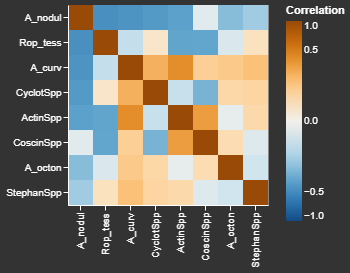

In [18]:
corr_mx = diatoms.set_index(['Age', 'Depth']).corr()

# melt corr_mx
corr_mx_long = corr_mx.reset_index().rename(
    columns = {'index': 'row'}
).melt(
    id_vars = 'row',
    var_name = 'col',
    value_name = 'Correlation'
)

# construct heatmap
fig5 = alt.Chart(corr_mx_long).mark_rect().encode(
    x = alt.X('col', title = '', sort = {'field': 'Correlation', 'order': 'ascending'}),
    y = alt.Y('row', title = '', sort = {'field': 'Correlation', 'order': 'ascending'}),
    color = alt.Color('Correlation', 
                      scale = alt.Scale(scheme = 'blueorange',
                                        domain = (-1, 1), 
                                        type = 'sqrt'),
                     legend = alt.Legend(tickCount = 5))
).properties(width = 200, height = 200)

# display
fig5

In [19]:
grader.check("q9")

q9 results: All test cases passed!

### Question 10: Computing and selecting principal components

Here you'll perform all of the calculations involved in PCA and check the variance ratios to select an appropriate number of principal components. The parts of this question correspond to the individual steps in this process.

**(i) Center and scale the data columns.**

For PCA it is usually recommended to center and scale the data; set Depth and Age as indices and center and scale the relative abundances. Store the normalized result as `pcdata`. 

**(ii) Compute the principal components.**

Compute *all 8* principal components. For this part you do not need to show any specific output.

**(iii) Examine the variance ratios.**

Create a dataframe called `pcvars` with the variance information by following these steps:

1. Store the proportion of variance explained (called `.explained_variance_ratio_` in the PCA output) as a dataframe named `pcvars` with just one column named `Proportion of variance explained`.
2. Add a column named `Component` to `pcvars` with the integers 1 through 8 as values (indicating the component number).
3. Add a column named `Cumulative variance explained` to `pcvars` that is the cumulative sum of `Proportion of variance explained`.
    + *Hint*: slice the `Proportion of variance explained` column and use `.cumsum(axis = ...)`.

For this part you do not need to show any specific output.

**(iv) Plot the variance explained by each PC.**

Use `pcvars` to construct a dual-axis plot showing the proportion of variance explained (left y axis) and cumulative variance explained (right y axis) as a function of component number (x axis), with points indicating the variance ratios and lines connecting the points. Follow these steps:

1. Construct a base chart that encodes only `Component` on the `X` channel. Store this as `base`.
2. Make a base layer for the proportion of variance explained that modifies `base` by encoding `Proportion of variance explained` on the `Y` channel. Store the result as `prop_var_base`.
    + Give the `Y` axis title a distinct color of your choosing via `alt.Y(..., axis = alt.Axis(titleColor = ...))`.
3. Make a base layer for the cumulative variance explained that modifies `base` by endocing `Cumulative variance explained` on the `Y` channel. Store the result as `cum_var_base`.
    + Give the `Y` axis title another distinct color of your choosing via `alt.Y(..., axis = alt.Axis(titleColor = ...))`.
4. Create a plot layer for the proportion of variance explained by combining points (`prop_var_base.mark_point()`) with lines (`prop_var_base.mark_line()`). Store the result as `cum_var`.
    + Apply the color you chose for the axis title to the points and lines.
5. Repeat the previous step for the cumulative variance explained.
    + Apply the color you chose for the axis title to the points and lines.
6. Layer the plots together using `alt.layer(l1, l2).resolve_scale(y = 'independent')`.

Store the result as `fig6` and display the figure.

**(v) How many PCs should be used?**

Propose an answer based on the variance explained plots and indicate how much total variation your proposed number of components capture jointly.

The 8 principle components jointly capture all of the explained variance but from looking at the graph, 3 of the components capture the majority of the variance which shows that the last few are not necessary. The cumulative variance explained by 2 of the principle components is 47 percent and 61 by 3.

In [20]:
## (i) center and scale data

# helper variable pcdata_raw; set Depth and Age as indices
pcdata_raw = diatoms.set_index(['Depth', 'Age'])

# center and scale the relative abundances
mean = pcdata_raw.mean()
std = pcdata_raw.std()

pcdata = (pcdata_raw - mean) / std

In [21]:
## (ii) compute pcs

pca = PCA(n_components = 8)
pca.fit(pcdata)

PCA(n_components=8)

In [22]:
## (iii) retrieve variance info

# store proportion of variance explained as a dataframe
pcvars = pd.DataFrame({'Proportion of variance explained' : pca.explained_variance_ratio_})

# add component number as a new column
pcvars['Component'] = range(1,9)

# add cumulative variance explained as a new column
pcvars['Cumulative variance explained'] = pcvars['Proportion of variance explained'].cumsum()
pcvars

,Proportion of variance explained,Component,Cumulative variance explained
0,0.255513,1,0.255513
1,0.223354,2,0.478867
2,0.132145,3,0.611012
3,0.122549,4,0.733560
4,0.110833,5,0.844394
5,0.077988,6,0.922382
6,0.067303,7,0.989684
7,0.010316,8,1.000000


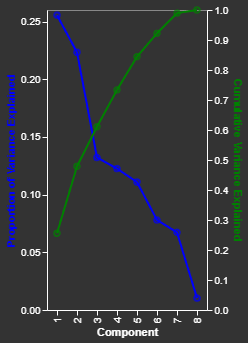

In [23]:
## (iv) plot variance explained

# encode component axis only as base layer
base = alt.Chart(pcvars).encode(
    x = alt.X('Component:O', title = 'Component')
)

# make a base layer for the proportion of variance explained
prop_var_base = base.encode(
    y = alt.Y('Proportion of variance explained:Q', axis = alt.Axis(titleColor ='blue'), title = 'Proportion of Variance Explained')
)
# make a base layer for the cumulative variance explained
cum_var_base = base.encode(
    y = alt.Y('Cumulative variance explained:Q', axis = alt.Axis(titleColor='green'), title = 'Cumulative Variance Explained')
)

# add points and lines to each base layer
prop_var = prop_var_base.mark_point(color = 'blue') + prop_var_base.mark_line(color = 'blue')
cum_var = cum_var_base.mark_point(color = 'green') + cum_var_base.mark_line(color = 'green')

# layer the layers
fig6 = alt.layer(prop_var, cum_var).resolve_scale(y = 'independent')

# display
fig6

In [24]:
grader.check("q10")

q10 results: All test cases passed!

Now that you've performed the calculations for PCA, you can move on to the fun/difficult part: figuring out what they say about the data.

The first step in this process is to examine the loadings. Each principal component is a linear combination of the relative abundances by taxon, and the loadings tell you *how* that combination is formed; the loadings are the linear combination coefficients, and thus correspond to the weight of each taxon in the corresponding principal component. Some useful points to keep in mind:

* a high loading value (negative or positive) indicates that a variable strongly influences the principal component;
* a negative loading value indicates that
    + increases in the value of a variable *decrease* the value of the principal component 
    + and decreases in the value of a variable *increase* the value of the principal component;
* a positive loading value indicates that 
    + increases in the value of a variable *increase* the value of the principal component
    + and decreases in the value of a variable *decrease* the value of the principal component;
* similar loadings between two or more variables indicate that the principal component reflects their *average*;
* divergent loadings between two sets of variables indicates that the principal component reflects their *difference*.

### Question 11: Interpreting component loadings

**(i) Extract the loadings from `pca`.**

Store the loadings for the first two principal components (called `.components_` in the PCA output) in a dataframe named `loading_df`. Name the columns `PC1` and `PC2`, and append a column `Taxon` with the corresponding variable names, and print the resulting dataframe.

**(ii) Construct loading plots**

Construct a line-and-point plot connecting the loadings of the first two principal components. Display the value of the loading on the y axis and the taxa names on the x axis, and show points indicating the loading values. Distinguish the PC's by color, and add lines connecting the loading values for each principal component. Store the result as `fig7` and display the figure -- you may need to resize for better readability.

*Hint*: you will need to first melt `loading_df` to long form with three columns -- the taxon name, the principal component (1 or 2), and the value of the loading.

**(iii) Interpret the first principal component.**

In a few sentences, answer the following questions.
1. Which taxa are up-weighted and which are down-weighted in this component?
2. How would you describe the principal component in context (*e.g.*, average abundance among a group, differences in abundances, etc.)?
3. How would you interpret a larger value of the PC versus a smaller value of the PC in terms of diatom communnity composition?

**(iv) Interpret the second principal component.**

Answer the same questions for component 2.

For PC1, A_nodul is the only taxon that is upweighted while the others are down-weighted. PC1 seems to indicate that A_nodul and A_curv has a large influence average abundances of taxons. A larger value of the PC would amount to a higher influence on the average abundances. For PC2, CytoSpp, Rop_tess, and StephenSpp are upweighted and the other taxons are downweighted. PC2 seems to indicate that Actin_Spp, coscin_spp, aand Rop_tess largely influence the average abundances of the taxons and similar to PC1, if this was a large value, then these taxons would be a large factor in the variation of abundance among the taxons.

In [25]:
## (i) retrieve loadings
# store the loadings as a data frame with appropriate names
loading_df = pd.DataFrame(pca.components_).iloc[:2, :].transpose().rename(columns = {0: 'PC1', 1: 'PC2'})
# add a column with the taxon names
loading_df['Taxon'] = diatom_summary.index

/opt/conda/lib/python3.11/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


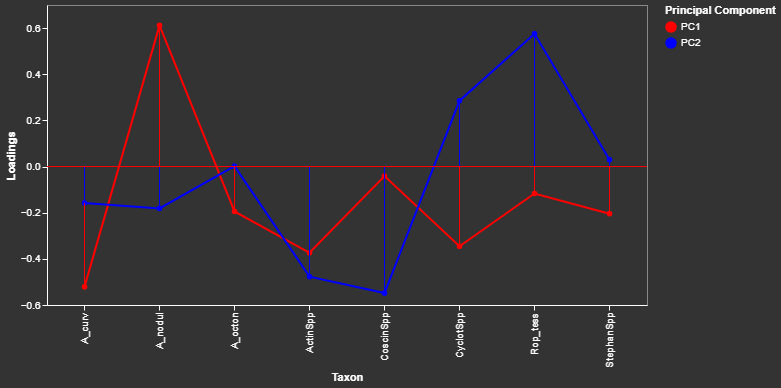

In [26]:
## (ii) construct loading plots
# melt from wide to long
loading_plot_df = loading_df.melt(
    id_vars = ['Taxon'],
    var_name = 'Principal Component',
    value_name = 'Loadings'
)

# create base layer with encoding
base = alt.Chart(loading_plot_df).encode(
    x = alt.X('Taxon:N', title = 'Taxon'),
    y = alt.Y('Loadings:Q', title = 'Loadings'),
    color = alt.Color('Principal Component:N', title='Principal Component', scale = alt.Scale(range = ['red', 'blue']))
)

# store horizontal line at zero
rule = alt.Chart(pd.DataFrame({'y': [0]})).mark_rule(color='red').encode(y='y:Q')

# layer points + lines + rule to construct loading plot
fig7 = (base.mark_line(point=True) + base.mark_rule(color='red') + rule).properties(
    width=600,
    height=300 
).configure_axis(grid=False)

# show
fig7

In [27]:
grader.check("q11")

q11 results: All test cases passed!

Recall that there was a shift in climate around 11,000 years ago, and *A. nodulifer* abundances seemed to differ before and after the shift. 

You can now use PCA to investigate whether not just individual abundances but *community composition* may have shifted around that time. To that end, let's think of the principal components as 'community composition indices':

* consider PC1 a nodulifer/non-nodulifer community composition index; and 
* consider PC2 a complex community composition index. 

A pattern of variation or covariation in the principal components can be thought of as reflecting a particular ecological community composition dynamic -- a way that community composition varies throughout time. Here you'll look for distinct patterns of variation/covariation before and after 11,000 years ago via an exploratory plot of the principal components.

### Question 12: Visualizing community composition shift

**(i) Project the centered and scaled data onto the first two component directions.**

This sounds a little more complicated than it is -- all that means is compute the values of the principal components for each data point. Create a dataframe called `projected_data` containing just the first two principal components as two columns named `PC1` and `PC2`, and two additional columns with the Age and Depth variables. 

**(ii) Construct a scatterplot of PC1 and PC2 by epoch.**

Construct a scatterplot of the principal components with observations colored according to whether they occurred in the Pleistocene or Holocene epoch. Store the result as `fig8` and display the figure.

**(iii) Comment on the plot: does there appear to be any change in community structure?**

Answer in a few sentences.

Based on the plot, there does appear to be a change in community structure from the Pleistocene epoch to the Holocene epoch. The complex community composition averages much higher in the Holocene epoch than in Pleistocene. Also, in the Pleistocene epoch, the nodulifer/non-nodulifer community composition averages higher than that during the Holocene Epoch.

In [28]:
## (i) project pcdata onto first two components; store as data frame

# retrieve principal component scores for pc1 and pc2
projected_data = pd.DataFrame(pca.transform(pcdata)).iloc[:, 0:2].rename(columns = {0: 'PC1', 1: 'PC2'})

# adjust index
projected_data.index = pcdata.index
projected_data = projected_data.reset_index()


/opt/conda/lib/python3.11/site-packages/altair/utils/core.py:410: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  col = df[col_name].apply(to_list_if_array, convert_dtype=False)


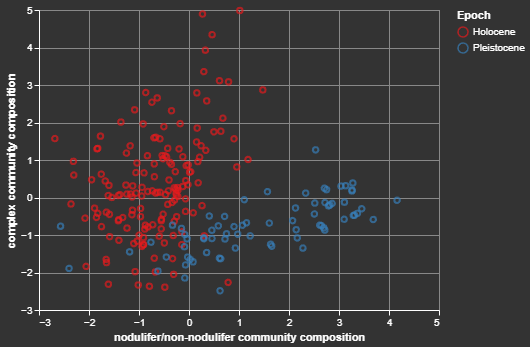

In [29]:
## (ii) construct scatterplot\

# works for projected_data but no legend
# fig8 = alt.Chart(proj_data).mark_point().encode(
#     x = alt.X('PC1:Q', title = 'nodulifer/non-nodulifer community composition'),
#     y = alt.Y('PC2:Q', title = 'complex community composition'),
#     color = alt.condition(alt.datum.Age > 11, alt.value('red'), alt.value('blue')),
# ).properties(
#     width=400,
#     height=300
# )

proj_data = projected_data.copy()
proj_data['Epoch'] = ['Pleistocene' if age > 11 else 'Holocene' for age in proj_data['Age']]

fig8 = alt.Chart(proj_data).mark_point().encode(
    x = alt.X('PC1:Q', title = 'nodulifer/non-nodulifer community composition'),
    y = alt.Y('PC2:Q', title = 'complex community composition'),
    color=alt.Color('Epoch:N', scale=alt.Scale(scheme='set1'), legend=alt.Legend(title='Epoch')),
).properties(
    width=400,
    height=300
)

# display
fig8

In [30]:
grader.check("q12")

q12 results: All test cases passed!

<!-- BEGIN QUESTION -->

### (Optional) Question 13: Multi-panel visualization

Sometimes it's helpful to see marginal distributions together with a scatterplot. Follow the steps below to create a multi-panel figure with marginal density estimates appended to the projected scatter from the previous question.

1. Create an Altair chart based on `projected_data` and use `.transform_calculate(...)` to define a variable `holocene` that indicates whether `Age` is older than 11,000 years. Store the result as `base`.
2. Modify `base` to add points with the following encodings. 
    + Pass PC1 to the `X` encoding channel and title the axis 'A. Nodulifer/non-A. nodulifer composition'.
    + Pass PC2 to the `Y` encoding channel and title the axis 'Complex community composition'.
    + Pass the variable you created in step 1. to the `color` encoding channel and title it 'Holocene'.
    Store the result as `scatter`.
3. Construct plots of kernel density estimates for each principal component conditional on age being older than 11,000 years:
    + modify `base` to create a `top_panel` plot with the KDE curves for PC1, with color corresponding to the age indicator from the `.transform_calculate(...)` step in making the base layer;
    + modify `base` again to create a `side_panel` plot with the KDE curves for PC2, rotated 90 degrees relative to the usual orientation (flip the typical axes), and with color corresponding to the age indicator from the `.transform_calculate(...)` step in making the base layer.
4. Then, resize these panels appropriately (top should be thin, side should be narrow), and use Altair's faceting operators `&` (vertical concatenation) and `|` (horizontal concatenation) to combine them with your scatterplot.

Store the result as `fig9` and display the figure.

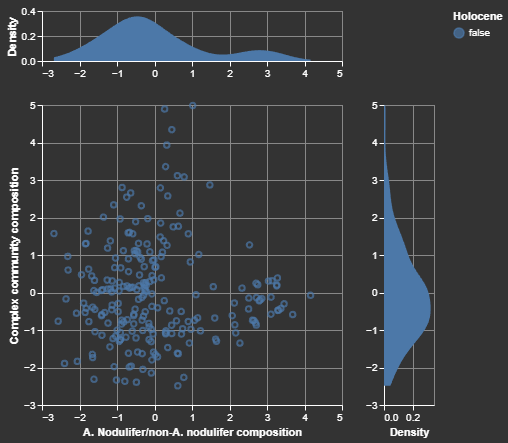

In [31]:
# make base layer
base = alt.Chart(projected_data).transform_calculate(
    holocene='datum.Age > 11000'
)

scatter = base.mark_point().encode(
    x=alt.X('PC1:Q', title='A. Nodulifer/non-A. nodulifer composition'),
    y=alt.Y('PC2:Q', title='Complex community composition'),
    color=alt.Color('holocene:N', title='Holocene')
)

#data scatter
top_panel = scatter.transform_density(
    density='PC1',
    groupby=['holocene'],
    as_=['PC1', 'density']
).mark_area(orient='vertical').encode(
    x=alt.X('PC1:Q', title=''),
    y=alt.Y('density:Q', title='Density'),
    color=alt.Color('holocene:N', title='Holocene')
).properties(
    width=300,  
    height=50  
)

# construct side panel (kdes for pc2)
side_panel = scatter.transform_density(
    density='PC2',
    groupby=['holocene'],
    as_=['PC2', 'density']
).mark_area(orient='horizontal').encode(
    y=alt.Y('PC2:Q', title=''),
    x=alt.X('density:Q', title='Density'),
    color=alt.Color('holocene:N', title='Holocene')
).properties(
    width=50,  
    height=300  
)

# facet
fig9 = top_panel & (scatter | side_panel)

# display
fig9


<!-- END QUESTION -->

# Communicating results

Take a moment to review and reflect on the results of your analysis in the previous parts. Think about how you would describe succinctly what you've learned from the diatom data.

<!-- BEGIN QUESTION -->

### Question 14: Summary

Write a brief paragraph (3-5 sentences) that addresses the following questions by referring to your results above.

* How would you characterize the typical ecological community composition of diatom taxa before and after 11,000 years ago?
    + *Hint*: focus on the side and top panels and the typical values of each index in the two time periods.
* Does the variation in ecological community composition over time seem to differ before and after 11,000 years ago?
    + *Hint*: focus on the shape of data scatter.


The typical ecological community composition of diatom taxa in the pleistocene period (or 11,000 + years ago) was mainly nodulifer/ non-nodulifers taxons but after the pleistocene epoch, the composition of the ecological community started to contain more complex taxons. After looking at the values, another thing we notice is the variation in both A_nodulifer composition and complex community composition across time. During the pleistocene Epoch, the variation in A_nodul/non-A nodul composition was greater than during the Holocene epoch and on the other hand, during the Holocene epoch, the complex community composition was more diverse than during the Pleistocene Epoch.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 15: Further work

What more might you like to know, given what you've learned? Pose a question that your exploratory analysis raises for you.


#### Answer

Given what I've learned, I think an interesting question would be why the variation and abundance of certain taxons changed from the Pleistocene Epoch to the Holocene Epoch. What other variables might have been influential in these changes?

<!-- END QUESTION -->

# Submission


1. Save the notebook. 
2. Restart the kernel and run all cells. (**CAUTION**: if your notebook is not saved, you will lose your work.)
3. Carefully look through your notebook and verify that all computations execute correctly and all graphics are displayed clearly. You should see **no errors**; if there are any errors, make sure to correct them before you submit the notebook.
4. Download the notebook as an `.ipynb` file. This is your backup copy.
5. Export the notebook as PDF and upload to Gradescope.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [32]:
grader.check_all()

q1 results: All test cases passed!

q10 results: All test cases passed!

q11 results: All test cases passed!

q12 results: All test cases passed!

q2 results: All test cases passed!

q3 results: All test cases passed!

q4 results: All test cases passed!

q5 results: All test cases passed!

q9 results: All test cases passed!